In [1]:
### dependencies ###
# !pip install cvxpy
# !pip install mystic

In [2]:
%matplotlib inline

# import cvxpy as cp
import numpy as np

import scipy.optimize as opt

import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# # verify runway plot

# t_sim = 10 # seconds

# center_line_x = np.zeros((t_sim,))
# left_boundary_x = np.ones((t_sim,)) * -10
# right_boundary_x = np.ones((t_sim)) * 10

# center_line_y = np.linspace(0, t_sim, t_sim)
# left_boundary_y = np.linspace(0, t_sim, t_sim)
# right_boundary_y = np.linspace(0, t_sim, t_sim)

# plt.figure(figsize=(20, 3))
# plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
# plt.plot(left_boundary_y, left_boundary_x, color='black')
# plt.plot(right_boundary_y, right_boundary_x, color='black')

In [4]:
### function to plot trajectory ###

def plot_trajectory(states, runway_length=(-100, 100), runway_boundaries=(-10, 10)):

    center_line_x = np.zeros((runway_length[1] - runway_length[0],))
    left_boundary_x = np.ones((runway_length[1] - runway_length[0],)) * runway_boundaries[0]
    right_boundary_x = np.ones((runway_length[1] - runway_length[0])) * runway_boundaries[1]

    center_line_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    left_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    right_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])

    plt.figure(figsize=(20, 3))
    plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
    plt.plot(left_boundary_y, left_boundary_x, color='black')
    plt.plot(right_boundary_y, right_boundary_x, color='black')
    
    colors = cm.rainbow(np.linspace(0, 1, int(len(states)//6)))
    for i in range(0, len(states), 6):
        x, y, _, h, _, _ = states[i:i+6]
        plt.plot(y, -x, marker='o', markersize=5, color=colors[int(i//6)])   

### print states after getting result ###
        
def print_states(states):
    for i in range(0, len(states), 6):
        print("state {}:".format(int(i//6) + 1))
        output_states = np.round(states[i:i+6], 5)
        print("\tx: {}, y: {}, velocity: {}, heading: {}\n\tacceleration: {}, angular velocity: {}\n".\
              format(output_states[0], output_states[1], output_states[2], output_states[3], 
                     output_states[4], output_states[5]))

***Controller Optimzed Over Controls***

In [5]:
### states setup ###

init_heading = 90 # degrees
init_velocity = 0 # m/s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 0
init_y = 0

# want to end here at t = sim_time
desired_x = 0
desired_y = 100

desired_velocity = 30 # m/s

acc_bounds = 5 # m/s^2
turning_bounds = 5 # degrees

time_step = 1
sim_time = 10

guess_range = (0, 10)

In [14]:
def compute_states(init_state, controls, time_step=1):
    states = []
    x, y, v, h = init_state
    for i in range(0, len(controls), 2):
        a, w = controls[i:i+2]
        states = np.concatenate((states, [x, y, v, h, a, w]))
        x += v * time_step * np.cos(np.radians(h))
        y += v * time_step * np.sin(np.radians(h))
        v += a * time_step
        h += w * time_step
    return states


def formulate_objective(init_states, desired_states, time_step=1, state_weight=0.1, 
                        control_weight=0.1, constraint_weight=0.1, dstate_weight=0.001):
    desired_x, desired_y, desired_v = desired_states
    def objective(params):
        states = compute_states(init_states, params, time_step=time_step)
        cost = control_weight * np.linalg.norm(np.vstack([params[0], params[1]]), ord=2) ** 2
        for i in range(6, len(states) - 6, 6):
            px, py, v, h, a, w = states[i:i+6]
            cost += constraint_weight * np.linalg.norm([px], ord=2) ** 2
            cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
            cost += state_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py, desired_v - v]), ord=2)
        px, py, v, h, a, w = states[-6:]
        cost += dstate_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py, desired_v - v]), ord=2)
        return cost
    return objective


def formulate_guess(sim_time, ts=1, random_seed=0):
    if random_seed:
        np.random.seed(random_seed)
    return np.random.randint(guess_range[0], guess_range[1], size=sim_time*2)
    
    
state0 = [init_x, init_y, init_velocity, init_heading]
init_guess = formulate_guess(sim_time)
bounds = [(-acc_bounds, acc_bounds), (-turning_bounds, turning_bounds)] * sim_time

obj = formulate_objective(state0, [desired_x, desired_y, desired_velocity], time_step=time_step, 
                          state_weight=1, constraint_weight=1, control_weight=0.5, dstate_weight=10)

result = opt.minimize(obj, init_guess, method='SLSQP', bounds=bounds,
                      options={'eps': 0.01, 'maxiter': 1000})
result

     fun: 634.8188756846096
     jac: array([-1.91813332e+00,  4.35081746e-02, -7.30491745e-02,  3.62691706e-02,
       -6.94026176e-02,  2.41330720e-02, -6.69954493e-02,  1.25719660e-02,
       -6.05185403e-02,  5.09290179e-03, -4.99575572e-02,  3.46073906e-03,
       -3.82230836e-02,  6.94243805e-03, -8.05817102e-01,  7.13224792e-03,
       -4.25050055e+00,  6.16885684e-03,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 328
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([ 5.00000000e+00, -1.83023435e-03,  3.87048049e+00, -4.95932689e-04,
        1.87528321e+00, -3.67244259e-04,  8.27807779e-01, -1.40985896e-03,
        7.10548420e-01, -1.92866755e-03,  1.50480831e+00,  1.06884440e-04,
        3.19543440e+00,  4.80725786e-03,  5.00000000e+00,  4.38291252e-03,
        5.00000000e+00,  1.16885683e-03,  5.00000000e+00,  1.00000000e+00])

state 1:
	x: 0.0, y: 0.0, velocity: 0.0, heading: 90.0
	acceleration: 5.0, angular velocity: -0.00183

state 2:
	x: 0.0, y: 0.0, velocity: 5.0, heading: 89.99817
	acceleration: 3.87048, angular velocity: -0.0005

state 3:
	x: 0.00016, y: 5.0, velocity: 8.87048, heading: 89.99767
	acceleration: 1.87528, angular velocity: -0.00037

state 4:
	x: 0.00052, y: 13.87048, velocity: 10.74576, heading: 89.99731
	acceleration: 0.82781, angular velocity: -0.00141

state 5:
	x: 0.00102, y: 24.61624, velocity: 11.57357, heading: 89.9959
	acceleration: 0.71055, angular velocity: -0.00193

state 6:
	x: 0.00185, y: 36.18982, velocity: 12.28412, heading: 89.99397
	acceleration: 1.50481, angular velocity: 0.00011

state 7:
	x: 0.00315, y: 48.47394, velocity: 13.78893, heading: 89.99407
	acceleration: 3.19543, angular velocity: 0.00481

state 8:
	x: 0.00457, y: 62.26286, velocity: 16.98436, heading: 89.99888
	acceleration: 5.0, angular velocity: 0.00438

state 9:
	x: 0.0049, y: 79.24723, velocity: 21.9843

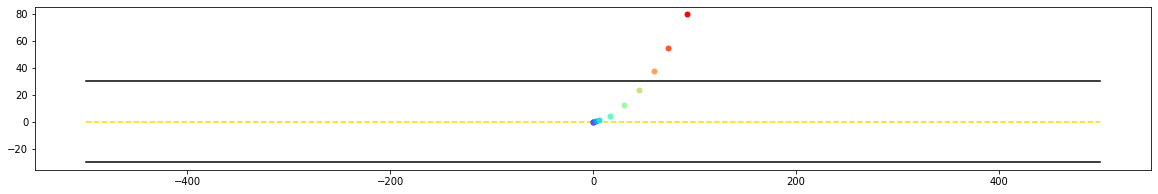

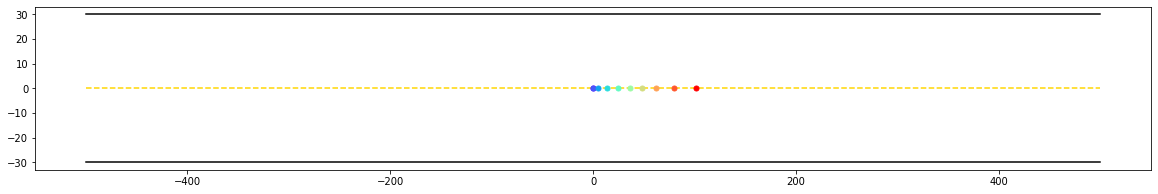

In [15]:
guess_traj = compute_states(state0, init_guess)
solved_traj = compute_states(state0, result.x)

plot_trajectory(guess_traj, runway_length=(-500, 500), runway_boundaries=(-30, 30))
plot_trajectory(solved_traj, runway_length=(-500, 500), runway_boundaries=(-30, 30))
 
print_states(solved_traj)

***Controller Optimized Over States***

In [43]:
### states setup ###

init_heading = 90 # degrees
init_velocity = 0 # m/s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 0
init_y = 0

# want to end here at t = sim_time
desired_x = 0
desired_y = 20

desired_velocity = 10 # m/s

# acceleration_constraint = 10 # m/s^2
# turning_constraint = 5 # degrees

time_step = 1
sim_time = 5

guess_range = (0, 3)

In [44]:
def shape_states(variables):
    states = variables[:4]
    controls = np.concatenate(([0, 0], variables[4:6]))
    controls[0] = states[2] * np.cos(np.radians(states[3]))
    controls[1] = states[2] * np.sin(np.radians(states[3]))
    return states, controls


def formulate_objective(desired_x, desired_y, desired_v, state_weight=0.1, control_weight=0.1, 
                        constraint_weight=0.1, dstate_weight=0.001):
    def objective(params):
        cost = 0
        cost += control_weight * np.linalg.norm(np.vstack([params[4], params[5]]), ord=2) ** 2
        for i in range(6, len(params) - 6, 6):
            px, py, v, h, a, w = params[i:i+6]
            cost += constraint_weight * np.linalg.norm([px], ord=2) ** 2
            cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
            cost += np.linalg.norm([desired_v - v], ord=2) ** 2
        px, py, v, h, a, w = params[-6:]
        cost += dstate_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py, desired_v - v]), ord=2)
        return cost
    return objective


def formulate_constraints(state0, sim_time, ts=1):
    def dynamic_constraints(params):
        errors = np.zeros((sim_time,))
        states_t, controls_t = shape_states(state0)
        errors[0] = np.linalg.norm(params[:4] - states_t, ord=2)
        for i in range(6, len(params), 6):    
            states_t1, controls_t1 = shape_states(params[i:i+6])
            # error[t+1] = norm(x_(t+1) - f(x_t, u_t))
            errors[int(i // 6)] = np.linalg.norm(states_t1 - (states_t + ts * controls_t), ord=2)
            states_t, controls_t = states_t1, controls_t1

        return np.sum(errors)
    return dynamic_constraints


def formulate_guess(state0, sim_time, random_seed=0, ts=1):
    
    guess_a = random.randint(guess_range[0], guess_range[1])
    guess_w = random.randint(guess_range[0], guess_range[1])
    state0_controlled = state0 + [guess_a, guess_w]
    init_state = state0_controlled[:]
    ix, iy, iv, ih, ia, iw = init_state
    
    for _ in range(sim_time - 1):
        
        new_x = ix + ts * iv * np.cos(np.radians(ih))
        new_y = iy + ts * iv * np.sin(np.radians(ih))
        new_v = iv + ts * ia
        new_h = ih + ts * iw
        guess_a = random.randint(guess_range[0], guess_range[1])
        guess_w = random.randint(guess_range[0], guess_range[1])
        init_state += [new_x, new_y, new_v, new_h, guess_a, guess_w]
        
        ix, iy, iv, ih, ia, iw = new_x, new_y, new_v, new_h, guess_a, guess_w
        
    return state0_controlled, np.array(init_state)

    
    
state0 = [init_x, init_y, init_velocity, init_heading]
state0, init_guess = formulate_guess(state0, sim_time, ts=time_step)

con = formulate_constraints(state0, sim_time, ts=time_step)
obj = formulate_objective(desired_x, desired_y, desired_velocity, state_weight=10, 
                          constraint_weight=1, control_weight=0.5, dstate_weight=10)

result = opt.minimize(obj, init_guess, method='SLSQP', 
                      constraints={"fun": con, "type": "eq"},
                      options={'eps': 0.1, 'maxiter': 500})
result

     fun: 66.74576419064655
     jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.34002248e-05, -5.50331305e-04, -3.16037075e+00,  0.00000000e+00,
       -1.06473561e+01,  0.00000000e+00,  3.52889111e+00, -5.17308062e+00,
       -3.60055692e+00,  0.00000000e+00, -3.04783560e+00,  0.00000000e+00,
        1.60234518e-01, -1.61390529e+00, -1.84653203e+00,  0.00000000e+00,
       -2.85643273e+00,  0.00000000e+00,  1.33799198e+00, -1.54680553e+00,
        5.60594314e+00, -5.84955364e+00, -4.27389594e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
 message: 'Iteration limit exceeded'
    nfev: 20443
     nit: 501
    njev: 500
  status: 9
 success: False
       x: array([-9.67086710e-02, -6.86408631e-02, -7.40097174e-02,  8.99881919e+01,
       -5.00134002e-02, -5.05503313e-02, -1.63018538e+00, -1.71172929e+00,
        4.62632194e+00,  8.94789489e+01,  3.47889111e+00, -5.22308062e+00,
       -1.85027846e+00,  2.83964609e+00,  8.4260822

errors: [0.00000000e+00 2.75896891e+01 1.86171964e-01 3.98891223e-03
 4.60812353e-03] 

state 1:
	x: -0.09671, y: -0.06864, velocity: -0.07401, heading: 89.98819
	acceleration: -0.05001, angular velocity: -0.05055

state 2:
	x: -1.63019, y: -1.71173, velocity: 4.62632, heading: 89.47895
	acceleration: 3.47889, angular velocity: -5.22308

state 3:
	x: -1.85028, y: 2.83965, velocity: 8.42608, heading: 84.16155
	acceleration: 0.11023, angular velocity: -1.66391

state 4:
	x: -0.97327, y: 11.27999, velocity: 8.52178, heading: 82.4929
	acceleration: 1.28799, angular velocity: -1.59681

state 5:
	x: 0.13332, y: 19.79222, velocity: 9.83135, heading: 80.9042
	acceleration: 2.0, angular velocity: 0.0



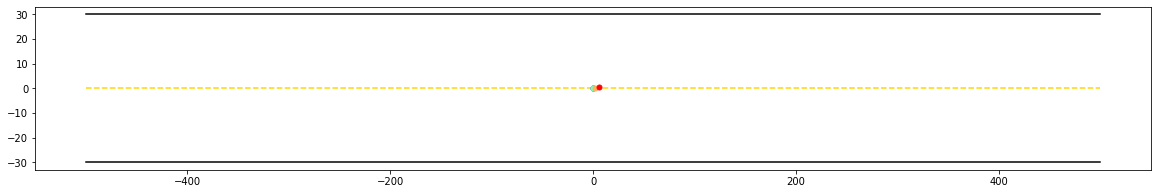

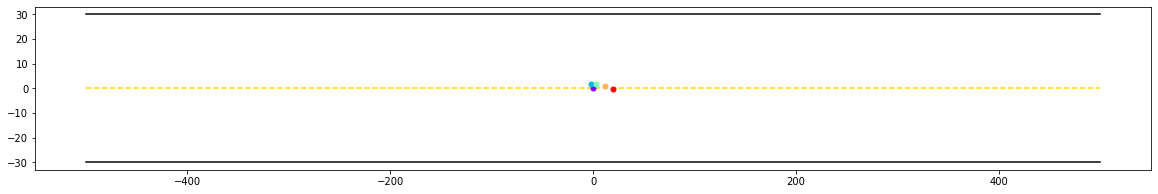

In [45]:
def get_controls(variables):
    controls = []
    for i in range(0, len(variables), 6):
        controls.append(variables[i+4])
        controls.append(variables[i+5])
    return controls

### verification for constraints ###

def verify_output(state0, params, sim_time, ts=1):
    errors = np.zeros((sim_time,))
    init_states, init_controls = shape_states(params[:6])
    errors[0] = np.linalg.norm(params[:4] - init_states, ord=2) ** 2

    for i in range(6, len(params), 6):    
        next_states, next_controls = shape_states(params[i:i+6])
        errors[int(i // 6)] = np.linalg.norm(next_states - (init_states + ts * init_controls), ord=2) ** 2
        init_states, init_controls = next_states, next_controls

    return errors

print("errors:", verify_output(state0, result.x, sim_time, ts=time_step), "\n")

plot_trajectory(init_guess, runway_length=(-500, 500), runway_boundaries=(-30, 30))
plot_trajectory(result.x, runway_length=(-500, 500), runway_boundaries=(-30, 30))
        
print_states(result.x)